In [1]:
#Predict whether a building is high performance or not using machine learning algorithms such as desicion tree and svm
from aibpd.data.preprocessing import PreprocessingCBECS
from aibpd.data.database import Database
import numpy as np
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt

Please select a database to continue the analysis


C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


heatingLevel exists, if you want to generate a new heatingLevel				please delete exists ones
dataDF in preprocessing shape (814, 715) level heatingLevel
top3 0.42833333333333334 top10 1.8888636363636364 top23 4.974313725490196 top25 5.3768375 top75 34.43789552238806 top90 61.38675


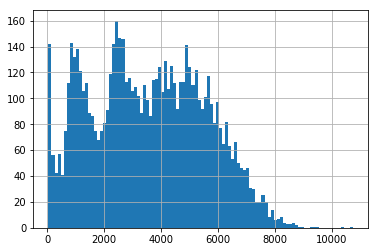

In [2]:
database=Database()
CBECS_DF=database.select()
CBECS_DF=CBECS_DF.fillna(0)
Preproc=PreprocessingCBECS()
CBECS_DF['HDD65'].hist(bins=100)
CBECS_DF=CBECS_DF[CBECS_DF['HDD65']>=3000][CBECS_DF['principleActivity']>=2][CBECS_DF['principleActivity']<3]
CBECS_DF=Preproc.forHeatingClf(CBECS_DF)

In [3]:
HP=CBECS_DF[CBECS_DF['heatingLevel']==1.0]
MP=CBECS_DF[CBECS_DF['heatingLevel']==2.0]
LP=CBECS_DF[CBECS_DF['heatingLevel']==0.0]
m1=HP.shape[0]
m2=MP.shape[0]
m3=LP.shape[0]
print(HP['EUIHeating'].mean(),HP['EUIHeating'].std())
print(MP['EUIHeating'].mean(),MP['EUIHeating'].std())
print(LP['EUIHeating'].mean(),LP['EUIHeating'].std())

3.530212407140227 1.044656121510872
18.089601955364895 8.30974942317932
45.300378181189885 7.660133516363987


In [4]:
CBECS_DF.shape

(814, 716)

In [5]:
def cumulativeBar(axN,n22,legends):
    dataN=n22[np.any(n22>0.0, axis=1)]
    print('legend num',len(legends),'row of data',dataN.shape)
    ncolumns=dataN.shape[1]
    ind=range(ncolumns)
    axN.bar(ind,dataN[0,:],label=str(legends[0]))
    sumN=dataN[0,:]
    for i in range(1,dataN.shape[0]):
        if i>=2:
            sumN+=dataN[i-1,:]
        axN.bar(ind,dataN[i,:],bottom=sumN,label=str(legends[i]))
    return axN

In [6]:
def getLegend(index,binsArr,legendDict):
    legendslist=[]
    keys=list(legendDict.keys())
    for i in range(index.shape[0]):
        if index[i]:
            v1=binsArr[i]
            v2=binsArr[i+1]
            for j in keys:
                if float(j)>=v1 and float(j)<=v2:
                    legendslist.append(legendDict[j])
                    keys.remove(j)
    return legendslist    

In [7]:
def highInfluenceFactorsDetect(name_str,bin_num,HP,MP,LP,m1,m2,m3):
    (n_buildingAreaCategory1, bins_buildingAreaCategory1, patches) = plt.hist(HP[name_str],bins=range(bin_num),density=False,weights= [1./m1] * m1)
    (n_buildingAreaCategory2, bins_buildingAreaCategory2, patches) = plt.hist(MP[name_str],bins=range(bin_num),density=False,weights= [1./m2] * m2)
    (n_buildingAreaCategory3, bins_buildingAreaCategory3, patches) = plt.hist(LP[name_str],bins=range(bin_num),density=False,weights= [1./m3] * m3)
    diff=(n_buildingAreaCategory1-n_buildingAreaCategory3)
    diff_max=np.amax(diff)
    print('Attributes Name',name_str,'max diff',diff_max)

In [8]:
def featureAnalysis(attri_name,bin_num,legends_dict_buildingAreaCategory,HP,MP,LP,m1,m2,m3):
    (n_buildingAreaCategory1, bins_buildingAreaCategory1, patches) = plt.hist(HP[attri_name],bins=range(bin_num),density=False,weights= [1./m1] * m1)
    (n_buildingAreaCategory2, bins_buildingAreaCategory2, patches) = plt.hist(MP[attri_name],bins=range(bin_num),density=False,weights= [1./m2] * m2)
    (n_buildingAreaCategory3, bins_buildingAreaCategory3, patches) = plt.hist(LP[attri_name],bins=range(bin_num),density=False,weights= [1./m3] * m3)
    diff=(n_buildingAreaCategory1-n_buildingAreaCategory3)
    diff_max=np.amax(np.absolute(diff))
    print('Attributes Name',attri_name,'max diff',diff_max)
    
    n_stacked_buildingAreaCategory=np.vstack((n_buildingAreaCategory1,n_buildingAreaCategory2))
    n_stacked_buildingAreaCategory=np.vstack((n_stacked_buildingAreaCategory,n_buildingAreaCategory3)).T
    index_buildingAreaCategory=np.any(n_stacked_buildingAreaCategory>0.0, axis=1)

    fig_buildingAreaCategory=plt.figure(figsize=(10,6))
    ax2=fig_buildingAreaCategory.add_subplot(1,1,1)
    ax2.set_ylabel('Percentage')
    ax2.set_title(attri_name+' distributions in different building groups')
    
    legendList_buildingAreaCategory=getLegend(index_buildingAreaCategory,bins_buildingAreaCategory1,legends_dict_buildingAreaCategory)
    cumulativeBar(ax2,n_stacked_buildingAreaCategory,legendList_buildingAreaCategory)
    h, l = ax2.get_legend_handles_labels()
    ax2.set_xticklabels(labels=('','','Low heating energy buildings','','Medium heating energy builsings','','High heating energy buildings'))
    ax2.set_yticklabels(labels=('0','20%','40%','60%','80%','100%'))
    ax2.legend(loc='center right',bbox_to_anchor=(1.55,0.5))
    fig_buildingAreaCategory.savefig('.\\'+attri_name+"Distribution-climate3000.jpg",dpi=300,bbox_inches='tight')

In [9]:
def make_figure(n_tuple,attri_name,legends_dict_buildingAreaCategory,bins_buildingAreaCategory1,anchor=(1.35, 0.5)):
    n_buildingAreaCategory1,n_buildingAreaCategory2,n_buildingAreaCategory3=n_tuple
    n_stacked_n_buildingAreaCategory=np.vstack((n_buildingAreaCategory1,n_buildingAreaCategory2))
    n_stacked_n_buildingAreaCategory=np.vstack((n_stacked_n_buildingAreaCategory,n_buildingAreaCategory3)).T
    index_buildingAreaCategory=np.any(n_stacked_n_buildingAreaCategory>0.0, axis=1)

    fig_buildingAreaCategory=plt.figure(figsize=(10,6))
    ax2=fig_buildingAreaCategory.add_subplot(1,1,1)
    ax2.set_ylabel('Percentage')
    #ax2.set_xlabel('buildingAreaCategory')
    #legends=np.unique(HP['principleActivity'].values)
    ax2.set_title(attri_name+' distributions in different building groups')
    
    legendList_buildingAreaCategory=getLegend(index_buildingAreaCategory,bins_buildingAreaCategory1,legends_dict_buildingAreaCategory)
    #print('legend num',len(legendList_buildingAreaCategory),'row of data',n_stacked_n_buildingAreaCategory.shape)
    cumulativeBar(ax2,n_stacked_n_buildingAreaCategory,legendList_buildingAreaCategory)
    h, l = ax2.get_legend_handles_labels()
    ax2.set_xticklabels(labels=('','','Low heating energy buildings','','Medium heating energy builsings','','High heating energy buildings'))
    ax2.set_yticklabels(labels=('0','20%','40%','60%','80%','100%'))
    ax2.legend(loc='center right',bbox_to_anchor=anchor)
    fig_buildingAreaCategory.savefig('.\\'+attri_name+"Distribution-climate.jpg",dpi=300,bbox_inches='tight')

In [10]:
from scipy.stats import chisquare
from collections import Counter
def printPvalue(featureName,HP,LP):
    feature_high=dict(Counter(HP[featureName]))
    feature_low=dict(Counter(LP[featureName]))
    list1=[]
    list2=[]
    for i in feature_high.keys():
        if i in feature_low.keys():
            list1.append(feature_high[i])
            list2.append(feature_low[i])
    chisq,pvalue=chisquare(list1,list2)
    print('p-value',featureName,'=',pvalue)

In [11]:
HP['OCCUPYPC']=pd.cut(HP['OCCUPYP'],5,labels=range(5))
MP['OCCUPYPC']=pd.cut(MP['OCCUPYP'],5,labels=range(5))
LP['OCCUPYPC']=pd.cut(LP['OCCUPYP'],5,labels=range(5))
CBECS_DF['OCCUPYPC']=pd.cut(CBECS_DF['OCCUPYP'],5,labels=range(5))

HP['HEATPC']=pd.cut(HP['HEATP'],[0,50,90,101],labels=[1,2,3])
MP['HEATPC']=pd.cut(MP['HEATP'],[0,50,90,101],labels=[1,2,3])
LP['HEATPC']=pd.cut(LP['HEATP'],[0,50,90,101],labels=[1,2,3])
CBECS_DF['HEATPC']=pd.cut(CBECS_DF['HEATP'],[0,50,90,101],labels=[1,2,3])

HP['HDD65C']=pd.cut(HP['HDD65'],[3000,4000,5000,6000,100000],labels=[1,2,3,4])
MP['HDD65C']=pd.cut(MP['HDD65'],[3000,4000,5000,6000,100000],labels=[1,2,3,4])
LP['HDD65C']=pd.cut(LP['HDD65'],[3000,4000,5000,6000,100000],labels=[1,2,3,4])
CBECS_DF['HDD65C']=pd.cut(CBECS_DF['HDD65'],[3000,4000,5000,6000,100000],labels=[1,2,3,4])

HP['HDD65C1']=pd.cut(HP['HDD65'],[3000,4000,5000,6000,7000,100000],labels=[1,2,3,4,5])
MP['HDD65C1']=pd.cut(MP['HDD65'],[3000,4000,5000,6000,7000,100000],labels=[1,2,3,4,5])
LP['HDD65C1']=pd.cut(LP['HDD65'],[3000,4000,5000,6000,7000,100000],labels=[1,2,3,4,5])
CBECS_DF['HDD65C1']=pd.cut(CBECS_DF['HDD65'],[3000,4000,5000,6000,7000,100000],labels=[1,2,3,4,5])

HP['MONUSEC']=pd.cut(HP['MONUSE'],[0,6,9,10,13],labels=[1,2,3,4])
MP['MONUSEC']=pd.cut(MP['MONUSE'],[0,6,9,10,13],labels=[1,2,3,4])
LP['MONUSEC']=pd.cut(LP['MONUSE'],[0,6,9,10,13],labels=[1,2,3,4])
CBECS_DF['MONUSEC']=pd.cut(CBECS_DF['MONUSE'],[0,6,9,10,13],labels=[1,2,3,4])

C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Attributes Name insulationUpgrade max diff 0.049180327868852465


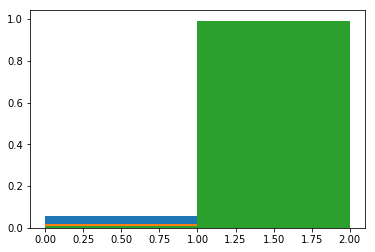

In [12]:
highInfluenceFactorsDetect('insulationUpgrade',3,HP,MP,LP,m1,m2,m3)

Attributes Name insulationUpgrade max diff 0.049180327868852465
Attributes Name buildingShape max diff 0.06557377049180335
Attributes Name HVACUpgrade max diff 0.049180327868852465
Attributes Name HEATPC max diff 0.08196721311475419
Attributes Name numFloors max diff 0.07377049180327877
Attributes Name buildingAreaCategory max diff 0.06557377049180335
Attributes Name WINTYP max diff 0.14754098360655743
Attributes Name RENWLL max diff 0.049180327868852465
Attributes Name HDD65C max diff 0.22950819672131173
Attributes Name HDD65C1 max diff 0.22950819672131173
Attributes Name HDD65C1 max diff 0.22950819672131173
Attributes Name OPNWE max diff 0.08196721311475419
Attributes Name MAINHT max diff 0.1721311475409838
Attributes Name yrConstructionCategory max diff 0.11475409836065581
Attributes Name principleActivity max diff 0.0
Attributes Name wallConstruction max diff 0.049180327868852514
Attributes Name WWR max diff 0.08196721311475419
Attributes Name WKHRSC max diff 0.032786885245901676
A

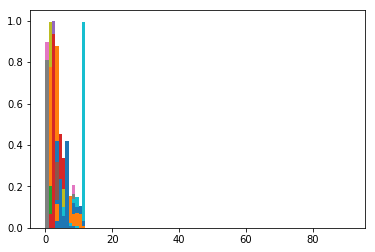

In [13]:
highInfluenceFactorsDetect('insulationUpgrade',3,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('buildingShape',12,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('HVACUpgrade',3,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('HEATPC',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('numFloors',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('buildingAreaCategory',10,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('WINTYP',5,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('RENWLL',5,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('HDD65C',6,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('HDD65C1',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('HDD65C1',8,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('OPNWE',4,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('MAINHT',9,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('yrConstructionCategory',11,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('principleActivity',92,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('wallConstruction',10,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('WWR',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('WKHRSC',8,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('OWNTYPE',9,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('MONUSE',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('region',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('censusRegion',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('climateZone',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('numEmployeesCategory',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('RENWLL',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('WHOPPR',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('roofConstuction',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('ELHT1',13,HP,MP,LP,m1,m2,m3)

In [14]:
printPvalue('MAINHT',HP,LP)
printPvalue('insulationUpgrade',HP,LP)
printPvalue('buildingShape',HP,LP)
printPvalue('HVACUpgrade',HP,LP)
printPvalue('numFloors',HP,LP)
printPvalue('buildingAreaCategory',HP,LP)
printPvalue('WINTYP',HP,LP)
printPvalue('RENWLL',HP,LP)
printPvalue('OPNWE',HP,LP)
printPvalue('yrConstructionCategory',HP,LP)
printPvalue('wallConstruction',HP,LP)
printPvalue('WWR',HP,LP)
printPvalue('OWNTYPE',HP,LP)
printPvalue('MONUSEC',HP,LP)
printPvalue('region',HP,LP)
printPvalue('censusRegion',HP,LP)
printPvalue('climateZone',HP,LP)
printPvalue('numEmployeesCategory',HP,LP)
printPvalue('RENWLL',HP,LP)
printPvalue('WHOPPR',HP,LP)
printPvalue('roofConstuction',HP,LP)
printPvalue('principleActivity',HP,LP)
printPvalue('WKHRSC',HP,LP)
#printPvalue('STHT1',HP,LP)
printPvalue('OCCUPYP',HP,LP)
printPvalue('ELHT1',HP,LP)
printPvalue('HEATPC',HP,LP)
printPvalue('HDD65C',HP,LP)
printPvalue('HDD65C1',HP,LP)

p-value MAINHT = 1.5843447465053629e-108
p-value insulationUpgrade = 1.1013906417181805e-08
p-value buildingShape = 1.6795758273027265e-05
p-value HVACUpgrade = 1.872421909978974e-09
p-value numFloors = 5.788071950194451e-05
p-value buildingAreaCategory = 0.05000379789858096
p-value WINTYP = 0.0017282987071285017
p-value RENWLL = 6.927198327517913e-10
p-value OPNWE = 0.06924337734843519
p-value yrConstructionCategory = 3.0573652488350494e-12
p-value wallConstruction = 0.5445615640232819
p-value WWR = 0.0015402655986004477
p-value OWNTYPE = 0.009251022335518859
p-value MONUSEC = 0.002511452200665632
p-value region = 3.9445770642694836e-19
p-value censusRegion = 1.0166421875779089e-23
p-value climateZone = 1.2620195207313314e-16
p-value numEmployeesCategory = 8.203334931062661e-05
p-value RENWLL = 6.927198327517913e-10
p-value WHOPPR = 0.04294188247177049
p-value roofConstuction = 4.9166868966854715e-08
p-value principleActivity = nan
p-value WKHRSC = 0.501447060543386
p-value OCCUPYP = 

C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


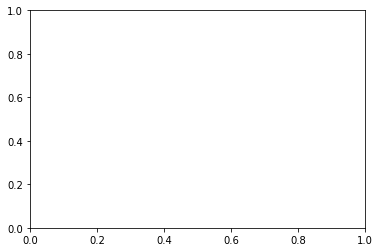

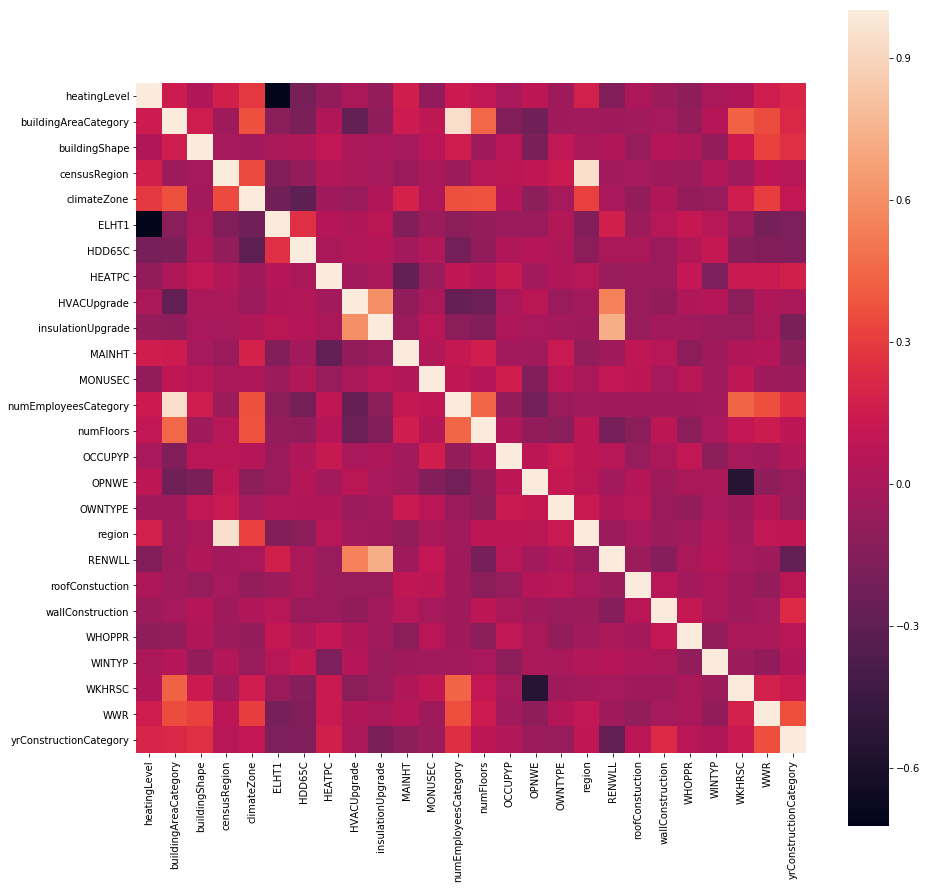

In [15]:
import matplotlib.pyplot as plt
import seaborn as sn
from pylab import savefig
fig,ax = plt.subplots()
corrMattDF=CBECS_DF[CBECS_DF['heatingLevel']<=1.0][CBECS_DF['heatingLevel']>=0.0][['heatingLevel','buildingAreaCategory','buildingShape','censusRegion','climateZone','ELHT1','HDD65C',\
                  'HEATPC','HVACUpgrade','insulationUpgrade','MAINHT','MONUSEC','numEmployeesCategory','numFloors','OCCUPYP','OPNWE',\
                  'OWNTYPE', 'region','RENWLL','roofConstuction','wallConstruction',\
                    'WHOPPR','WINTYP','WKHRSC','WWR','yrConstructionCategory']]
corrMattDF['HDD65C']=corrMattDF['HDD65C'].astype('int')
corrMattDF['HEATPC']=corrMattDF['HEATPC'].astype('int')
corrMattDF['MONUSEC']=corrMattDF['MONUSEC'].astype('int')
corrMatt=corrMattDF.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax1 = plt.subplots(figsize=(15,15)) 
ax=sn.heatmap(corrMatt,square=True,ax=ax1)
figure = ax.get_figure()    
figure.savefig('corr_new15.jpg', dpi=300)

In [16]:
corrMatt

,heatingLevel,buildingAreaCategory,buildingShape,censusRegion,climateZone,ELHT1,HDD65C,HEATPC,HVACUpgrade,insulationUpgrade,...,OWNTYPE,region,RENWLL,roofConstuction,wallConstruction,WHOPPR,WINTYP,WKHRSC,WWR,yrConstructionCategory
heatingLevel,1.000000,0.143830,0.025368,0.166557,0.281741,-0.721923,-0.199212,-0.091150,0.007401,-0.079367,...,-0.040613,0.176129,-0.163538,0.016555,-0.050633,-1.023038e-01,0.000000,0.030112,0.149451,0.206224
buildingAreaCategory,0.143830,1.000000,0.152465,-0.048899,0.372723,-0.125207,-0.179169,0.030123,-0.288556,-0.100025,...,-0.041381,-0.035516,-0.040753,-0.033571,-0.012896,-8.452223e-02,0.039311,0.433317,0.357390,0.215514
buildingShape,0.025368,0.152465,1.000000,-0.011523,-0.018973,0.001661,0.021489,0.098198,-0.001690,-0.004499,...,0.092717,0.006950,0.024950,-0.072714,0.046275,2.130297e-02,-0.079727,0.135455,0.324951,0.250308
censusRegion,0.166557,-0.048899,-0.011523,1.000000,0.350711,-0.158751,-0.086373,0.034918,0.009749,-0.011750,...,0.132189,0.952323,-0.025072,-0.012674,-0.045452,-5.368376e-02,0.036080,-0.029966,0.071944,0.053020
climateZone,0.281741,0.372723,-0.018973,0.350711,1.000000,-0.229817,-0.301490,-0.039666,-0.057451,0.022002,...,-0.010732,0.319943,-0.007841,-0.083787,0.026427,-8.199859e-02,-0.068335,0.157740,0.305850,0.102733
ELHT1,-0.721923,-0.125207,0.001661,-0.158751,-0.229817,1.000000,0.250755,0.047651,0.018116,0.071493,...,0.037641,-0.155338,0.166067,-0.051515,0.054079,1.187418e-01,0.053427,-0.058886,-0.201815,-0.174282
HDD65C,-0.199212,-0.179169,0.021489,-0.086373,-0.301490,0.250755,1.000000,0.002654,0.036970,0.041757,...,0.018144,-0.116507,0.003759,0.006342,-0.058044,3.439146e-02,0.118699,-0.140995,-0.159665,-0.163687
HEATPC,-0.091150,0.030123,0.098198,0.034918,-0.039666,0.047651,0.002654,1.000000,-0.027387,0.010128,...,0.022952,0.054279,-0.065962,-0.060661,-0.059998,1.093361e-01,-0.171707,0.131930,0.126099,0.168321
HVACUpgrade,0.007401,-0.288556,-0.001690,0.009749,-0.057451,0.018116,0.036970,-0.027387,1.000000,0.600994,...,-0.061499,-0.018248,0.543560,-0.065055,-0.095372,2.488966e-02,0.044320,-0.123035,0.020096,-0.001725
insulationUpgrade,-0.079367,-0.100025,-0.004499,-0.011750,0.022002,0.071493,0.041757,0.010128,0.600994,1.000000,...,-0.022921,-0.049259,0.730276,-0.068834,-0.024303,-3.529738e-02,-0.061242,-0.067950,0.002611,-0.177379


In [21]:
database.datasetDF=corrMattDF
database.save(name='CBECS4Clf')

datasetDF has been saved to C:/Users/tzcha/Documents/aibpd/resources/CBECS4Clf.csv


In [17]:
CBECS_DF_clf=CBECS_DF[CBECS_DF['heatingLevel']<=1.0][CBECS_DF['heatingLevel']>=0.0][[]].values
np.save('CBECS_DF_clf3',CBECS_DF_clf)

C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


'buildingAreaCategory0','buildingShape1','censusRegion2',     'climateZone3','ELHT14','HDD65C5','HEATPC6','HVACUpgrade7','insulationUpgrade8','MAINHT9',               'MONUSEC10','numEmployeesCategory11','numFloors12','OCCUPYP13','OPNWE14','OWNTYPE15', 'region16',            'RENWLL17','roofConstuction18','wallConstruction19','WHOPPR20','WINTYP21','WKHRSC22','WWR23',
 'yrConstructionCategory24','heatingLevel'

In [19]:
CBECS_DF_clf_HT=CBECS_DF[CBECS_DF['heatingLevel']<=1.0][CBECS_DF['heatingLevel']>=0.0][['buildingAreaCategory',\
                'buildingShape','censusRegion','climateZone','HDD65C',\
                  'HEATPC','HVACUpgrade','insulationUpgrade','MAINHT','MONUSEC','numEmployeesCategory',\
                'numFloors','OCCUPYP','OPNWE','OWNTYPE', 'region','RENWLL','roofConstuction','wallConstruction',\
                    'WHOPPR','WINTYP','WKHRSC','WWR','yrConstructionCategory','heatingLevel']]
CBECS_DF_clf_HT['HDD65C']=CBECS_DF_clf_HT['HDD65C'].astype('int')
CBECS_DF_clf_HT['HEATPC']=CBECS_DF_clf_HT['HEATPC'].astype('int')
CBECS_DF_clf_HT['MONUSEC']=CBECS_DF_clf_HT['MONUSEC'].astype('int')
np.save('CBECS_DF_clf_HT',CBECS_DF_clf_HT.values)

C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [20]:
X=corrMattDF[['buildingAreaCategory','buildingShape','censusRegion','climateZone','ELHT1','HDD65C',\
                  'HEATPC','HVACUpgrade','insulationUpgrade','MAINHT','MONUSEC','numEmployeesCategory','numFloors','OCCUPYP','OPNWE',\
                  'OWNTYPE', 'region','RENWLL','roofConstuction','wallConstruction',\
                    'WHOPPR','WINTYP','WKHRSC','WWR','yrConstructionCategory']].values
Y=corrMattDF['heatingLevel'].values
m=corrMattDF.shape[0]
n=int(0.7*m)

In [24]:
column=['buildingAreaCategory','buildingShape','censusRegion','climateZone','ELHT1','HDD65C',\
                  'HEATPC','HVACUpgrade','insulationUpgrade','MAINHT','MONUSEC','numEmployeesCategory','numFloors','OCCUPYP','OPNWE',\
                  'OWNTYPE', 'region','RENWLL','roofConstuction','wallConstruction',\
                    'WHOPPR','WINTYP','WKHRSC','WWR','yrConstructionCategory']

In [22]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
X_train, X_test, y_train, y_test = train_test_split(
    corrMattDF.values[:,1:],
    corrMattDF.values[:,0],
    test_size=0.2,
    random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()
for j in range(1,25):
    #print('Training dataset shape:', X_train.shape, y_train.shape)
    #print('Testing dataset shape:', X_test.shape, y_test.shape)
    #j1=25-j
    clf = svm.SVC()
    sfs1 = sfs(clf,
               k_features=j,
               forward=True,
               floating=False,
               verbose=2,
               scoring='accuracy',
               cv=5)

    # Perform SFFS
    sfs1 = sfs1.fit(corrMattDF.values[:,1:], corrMattDF.values[:,0])
    feat_cols = list(sfs1.k_feature_idx_)
    print(feat_cols)
    for i in feat_cols:
        print(column[i])

    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)
    errorList=[]
    X1=X[:,feat_cols]
    Y1=Y
    for train_index, test_index in kf.split(X1,Y1):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = Y1[train_index], Y1[test_index]
        clf2 = svm.SVC(gamma='auto')
        clf2.fit(X_train,y_train) 
        error=1-clf2.score(X_test,y_test)
        errorList.append(error)
    error2=np.mean(errorList)
    print(1-error2)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:56:50] Features: 1/1 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[4]
ELHT1
0.8567176870748299


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:56:50] Features: 1/2 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:56:50] Features: 2/2 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[3, 4]
climateZone
ELHT1
0.8648809523809524


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:56:51] Features: 1/3 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:56:51] Features: 2/3 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:56:51] Features: 3/3 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[3, 4, 10]
climateZone
ELHT1
MONUSEC
0.8730442176870749


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:56:51] Features: 1/4 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:56:51] Features: 2/4 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:56:51] Features: 3/4 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:56:52] Features: 4/4 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[3, 4, 5, 10]
climateZone
ELHT1
HDD65C
MONUSEC
0.8689625850340137


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:56:52] Features: 1/5 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:56:52] Features: 2/5 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:56:52] Features: 3/5 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:56:52] Features: 4/5 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:56:53] Features: 5/5 -- score: 0.873

[3, 4, 5, 6, 10]
climateZone
ELHT1
HDD65C
HEATPC
MONUSEC
0.8566326530612245


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:56:53] Features: 1/6 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:56:53] Features: 2/6 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:56:53] Features: 3/6 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:56:53] Features: 4/6 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:

[3, 4, 5, 6, 8, 10]
climateZone
ELHT1
HDD65C
HEATPC
insulationUpgrade
MONUSEC
0.8607142857142858


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished

[2019-05-06 09:56:54] Features: 1/7 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:56:54] Features: 2/7 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:56:54] Features: 3/7 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:56:55] Features: 4/7 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:56:55] Features: 5/7 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | 

[3, 4, 5, 6, 7, 8, 10]
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MONUSEC
0.8566326530612245


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:56:55] Features: 1/8 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:56:55] Features: 2/8 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:56:56] Features: 3/8 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:56:56] Features: 4/8 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:

[1, 3, 4, 5, 6, 7, 8, 10]
buildingShape
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MONUSEC
0.8320578231292517


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:56:57] Features: 1/9 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:56:57] Features: 2/9 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:56:57] Features: 3/9 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:56:57] Features: 4/9 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:56:57] Features: 5/9 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | 

[1, 3, 4, 5, 6, 7, 8, 10, 21]
buildingShape
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MONUSEC
WINTYP
0.8443877551020408


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:56:58] Features: 1/10 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:56:59] Features: 2/10 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:56:59] Features: 3/10 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:56:59] Features: 4/10 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06

[1, 3, 4, 5, 6, 7, 8, 10, 17, 21]
buildingShape
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MONUSEC
RENWLL
WINTYP
0.8403061224489796


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:00] Features: 1/11 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:00] Features: 2/11 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:01] Features: 3/11 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:01] Features: 4/11 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:01] Features: 5/11 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[1, 3, 4, 5, 6, 7, 8, 10, 14, 17, 21]
buildingShape
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MONUSEC
OPNWE
RENWLL
WINTYP
0.8362244897959183


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:02] Features: 1/12 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:02] Features: 2/12 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:03] Features: 3/12 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:03] Features: 4/12 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:03] Features: 5/12 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[1, 3, 4, 5, 6, 7, 8, 10, 14, 17, 20, 21]
buildingShape
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MONUSEC
OPNWE
RENWLL
WHOPPR
WINTYP
0.8362244897959183


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:04] Features: 1/13 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:05] Features: 2/13 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:05] Features: 3/13 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:05] Features: 4/13 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:05] Features: 5/13 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[1, 3, 4, 5, 6, 7, 8, 10, 14, 17, 20, 21, 23]
buildingShape
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MONUSEC
OPNWE
RENWLL
WHOPPR
WINTYP
WWR
0.8198979591836735


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:07] Features: 1/14 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:07] Features: 2/14 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:07] Features: 3/14 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:07] Features: 4/14 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:07] Features: 5/14 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[1, 3, 4, 5, 6, 7, 8, 10, 14, 17, 20, 21, 22, 23]
buildingShape
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MONUSEC
OPNWE
RENWLL
WHOPPR
WINTYP
WKHRSC
WWR
0.8075680272108843


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:09] Features: 1/15 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:09] Features: 2/15 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:09] Features: 3/15 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:10] Features: 4/15 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:10] Features: 5/15 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[1, 3, 4, 5, 6, 7, 8, 10, 14, 16, 17, 20, 21, 22, 23]
buildingShape
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MONUSEC
OPNWE
region
RENWLL
WHOPPR
WINTYP
WKHRSC
WWR
0.8198129251700681


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished

[2019-05-06 09:57:12] Features: 1/16 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:12] Features: 2/16 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:12] Features: 3/16 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:12] Features: 4/16 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:12] Features: 5/16 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[1, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 17, 20, 21, 22, 23]
buildingShape
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
OPNWE
region
RENWLL
WHOPPR
WINTYP
WKHRSC
WWR
0.7993197278911565


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:14] Features: 1/17 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:14] Features: 2/17 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:15] Features: 3/17 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:15] Features: 4/17 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:15] Features: 5/17 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 17, 20, 21, 22, 23]
buildingShape
censusRegion
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
OPNWE
region
RENWLL
WHOPPR
WINTYP
WKHRSC
WWR
0.803656462585034


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:17] Features: 1/18 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:17] Features: 2/18 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:17] Features: 3/18 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:18] Features: 4/18 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:18] Features: 5/18 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 17, 20, 21, 22, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
OPNWE
region
RENWLL
WHOPPR
WINTYP
WKHRSC
WWR
0.7832482993197278


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:20] Features: 1/19 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:20] Features: 2/19 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:20] Features: 3/19 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:21] Features: 4/19 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:21] Features: 5/19 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 17, 20, 21, 22, 23, 24]
buildingAreaCategory
buildingShape
censusRegion
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
OPNWE
region
RENWLL
WHOPPR
WINTYP
WKHRSC
WWR
yrConstructionCategory
0.7585884353741497


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:23] Features: 1/20 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:23] Features: 2/20 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:23] Features: 3/20 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:24] Features: 4/20 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:24] Features: 5/20 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 17, 20, 21, 22, 23, 24]
buildingAreaCategory
buildingShape
censusRegion
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
OPNWE
region
RENWLL
WHOPPR
WINTYP
WKHRSC
WWR
yrConstructionCategory
0.7298469387755102


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:26] Features: 1/21 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:26] Features: 2/21 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:26] Features: 3/21 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:27] Features: 4/21 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:27] Features: 5/21 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 20, 21, 22, 23, 24]
buildingAreaCategory
buildingShape
censusRegion
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
OPNWE
OWNTYPE
region
RENWLL
WHOPPR
WINTYP
WKHRSC
WWR
yrConstructionCategory
0.7050170068027211


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:29] Features: 1/22 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:29] Features: 2/22 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished

[2019-05-06 09:57:30] Features: 3/22 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:30] Features: 4/22 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:30] Features: 5/22 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 20, 21, 22, 23, 24]
buildingAreaCategory
buildingShape
censusRegion
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
numFloors
OPNWE
OWNTYPE
region
RENWLL
WHOPPR
WINTYP
WKHRSC
WWR
yrConstructionCategory
0.6803571428571429


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:33] Features: 1/23 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:33] Features: 2/23 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:33] Features: 3/23 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:33] Features: 4/23 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06 09:57:33] Features: 5/23 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24]
buildingAreaCategory
buildingShape
censusRegion
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
numFloors
OPNWE
OWNTYPE
region
RENWLL
wallConstruction
WHOPPR
WINTYP
WKHRSC
WWR
yrConstructionCategory
0.6803571428571429


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2019-05-06 09:57:36] Features: 1/24 -- score: 0.8565000000000002[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2019-05-06 09:57:36] Features: 2/24 -- score: 0.8648333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2019-05-06 09:57:36] Features: 3/24 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2019-05-06 09:57:37] Features: 4/24 -- score: 0.873[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2019-05-06

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
buildingAreaCategory
buildingShape
censusRegion
climateZone
ELHT1
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
numFloors
OPNWE
OWNTYPE
region
RENWLL
roofConstuction
wallConstruction
WHOPPR
WINTYP
WKHRSC
WWR
yrConstructionCategory
0.6599489795918367


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2019-05-06 09:57:39] Features: 21/24 -- score: 0.7461666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2019-05-06 09:57:39] Features: 22/24 -- score: 0.7221666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2019-05-06 09:57:39] Features: 23/24 -- score: 0.7058333333333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2019-05-06 09:57:39] Features: 24/24 -- score: 0.653

In [30]:
 CBECS_DF_clf_HT.values[:,:-1]

array([[9, 1.0, 4, ..., 4, 4.0, 6],
       [8, 2.0, 3, ..., 6, 4.0, 8],
       [4, 2.0, 8, ..., 4, 3.0, 9],
       ...,
       [7, 2.0, 3, ..., 4, 3.0, 8],
       [2, 1.0, 5, ..., 2, 4.0, 5],
       [7, 2.0, 9, ..., 4, 3.0, 1]], dtype=object)

In [50]:
for j in range(1,24):
    clf = svm.SVC()
    sfs2 = sfs(clf,
               k_features=j,
               forward=False,
               floating=False,
               verbose=2,
               scoring='accuracy',
               cv=5)

    # Perform SFFS
    sfs2 = sfs2.fit(CBECS_DF_clf_HT.values[:,:-1], CBECS_DF_clf_HT.values[:,-1])
    feat_cols = list(sfs2.k_feature_idx_)
    print(feat_cols)
    for i in feat_cols :
            print(list(CBECS_DF_clf_HT.columns)[i])

    kf = KFold(n_splits=5)
    errorList=[]
    X1=CBECS_DF_clf_HT.values[:,feat_cols]
    Y1=CBECS_DF_clf_HT.values[:,-1]
    for train_index, test_index in kf.split(X1,Y1):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = Y1[train_index], Y1[test_index]
        clf2 = svm.SVC(gamma='auto')
        clf2.fit(X_train,y_train) 
        error=1-clf2.score(X_test,y_test)
        errorList.append(error)
    error2=np.mean(errorList)
    print(error2)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:18] Features: 23/1 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:18] Features: 22/1 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:19] Features: 21/1 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished

[2019-04-11 11:10:19] Features: 20/1 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    

[3]
climateZone
0.3153061224489796


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:22] Features: 23/2 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:23] Features: 22/2 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:23] Features: 21/2 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:10:23] Features: 20/2 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished

[2019-04-11 11:10:24] Features: 19/2 -- score: 0.6606666666666667

[3, 8]
climateZone
MAINHT
0.20442176870748302


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:27] Features: 23/3 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:27] Features: 22/3 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:27] Features: 21/3 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:10:28] Features: 20/3 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    

[3, 8, 16]
climateZone
MAINHT
RENWLL
0.20442176870748302


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:31] Features: 23/4 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:31] Features: 22/4 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:32] Features: 21/4 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished

[2019-04-11 11:10:32] Features: 20/4 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    

[0, 3, 8, 16]
buildingAreaCategory
climateZone
MAINHT
RENWLL
0.20892857142857144


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:35] Features: 23/5 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:36] Features: 22/5 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:36] Features: 21/5 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:10:36] Features: 20/5 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    

[0, 3, 8, 10, 16]
buildingAreaCategory
climateZone
MAINHT
numEmployeesCategory
RENWLL
0.22142857142857145


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:40] Features: 23/6 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:40] Features: 22/6 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:41] Features: 21/6 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished

[2019-04-11 11:10:41] Features: 20/6 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:10:41] Features: 19/6 -- score: 0.6606666666666667

[0, 3, 5, 8, 10, 16]
buildingAreaCategory
climateZone
HEATPC
MAINHT
numEmployeesCategory
RENWLL
0.221343537414966


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:44] Features: 23/7 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:44] Features: 22/7 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:45] Features: 21/7 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:10:45] Features: 20/7 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:10:45] Features: 19/7 -- score: 0.6606666666666667

[0, 3, 5, 7, 8, 10, 16]
buildingAreaCategory
climateZone
HEATPC
insulationUpgrade
MAINHT
numEmployeesCategory
RENWLL
0.23775510204081635


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:48] Features: 23/8 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:48] Features: 22/8 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:49] Features: 21/8 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:10:49] Features: 20/8 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:10:49] Features: 19/8 -- score: 0.6606666666666667

[0, 2, 3, 5, 7, 8, 10, 16]
buildingAreaCategory
censusRegion
climateZone
HEATPC
insulationUpgrade
MAINHT
numEmployeesCategory
RENWLL
0.24982993197278916


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:52] Features: 23/9 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:52] Features: 22/9 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:53] Features: 21/9 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:10:53] Features: 20/9 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:10:53] Features: 19/9 -- score: 0.6606666666666667

[0, 2, 3, 5, 6, 7, 8, 10, 16]
buildingAreaCategory
censusRegion
climateZone
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
numEmployeesCategory
RENWLL
0.24158163265306126


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:10:56] Features: 23/10 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:10:56] Features: 22/10 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:10:57] Features: 21/10 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished

[2019-04-11 11:10:57] Features: 20/10 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:10:57] Features: 19/10 -- score: 0.66066666666

[0, 2, 3, 5, 6, 7, 8, 10, 16, 19]
buildingAreaCategory
censusRegion
climateZone
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
numEmployeesCategory
RENWLL
WHOPPR
0.24974489795918364


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:11:00] Features: 23/11 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:00] Features: 22/11 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:11:01] Features: 21/11 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished

[2019-04-11 11:11:01] Features: 20/11 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:11:01] Features: 19/11 -- score: 0.66066666666

[0, 1, 2, 3, 5, 6, 7, 8, 10, 16, 19]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
numEmployeesCategory
RENWLL
WHOPPR
0.2948129251700681


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:11:04] Features: 23/12 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:04] Features: 22/12 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:11:04] Features: 21/12 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:11:05] Features: 20/12 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:11:05] Features: 19/12 -- score: 0.66066666666

[0, 1, 2, 3, 5, 6, 7, 8, 10, 16, 18, 19]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
numEmployeesCategory
RENWLL
wallConstruction
WHOPPR
0.3235544217687075


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:11:07] Features: 23/13 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:07] Features: 22/13 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:11:08] Features: 21/13 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished

[2019-04-11 11:11:08] Features: 20/13 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:11:08] Features: 19/13 -- score: 0.66066666666

[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 16, 18, 19]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
numEmployeesCategory
numFloors
RENWLL
wallConstruction
WHOPPR
0.36471088435374155


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:11:10] Features: 23/14 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:11] Features: 22/14 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:11:11] Features: 21/14 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:11:12] Features: 20/14 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:

[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 16, 18, 19, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
numEmployeesCategory
numFloors
RENWLL
wallConstruction
WHOPPR
yrConstructionCategory
0.3812925170068027


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:11:14] Features: 23/15 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:14] Features: 22/15 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:11:14] Features: 21/15 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:11:15] Features: 20/15 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:11:15] Features: 19/15 -- score: 0.66066666666

[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 16, 18, 19, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
numEmployeesCategory
numFloors
OCCUPYP
RENWLL
wallConstruction
WHOPPR
yrConstructionCategory
0.34447278911564627


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:11:17] Features: 23/16 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:17] Features: 22/16 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:11:17] Features: 21/16 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:11:18] Features: 20/16 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished

[2019-04-11 11:11:18] Features: 19/16 -- score: 0.66066666666

[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 16, 17, 18, 19, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
numEmployeesCategory
numFloors
OCCUPYP
RENWLL
roofConstuction
wallConstruction
WHOPPR
yrConstructionCategory
0.3404761904761905


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:11:19] Features: 23/17 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:20] Features: 22/17 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:11:20] Features: 21/17 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:11:20] Features: 20/17 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:11:21] Features: 19/17 -- score: 0.66066666666

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 16, 17, 18, 19, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
numEmployeesCategory
numFloors
OCCUPYP
RENWLL
roofConstuction
wallConstruction
WHOPPR
yrConstructionCategory
0.3403061224489796


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2019-04-11 11:11:22] Features: 23/18 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:22] Features: 22/18 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.2s finished

[2019-04-11 11:11:23] Features: 21/18 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:11:23] Features: 20/18 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:11:23] Features: 19/18 -- score: 0.66066666666

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 19, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
numFloors
OCCUPYP
RENWLL
roofConstuction
wallConstruction
WHOPPR
yrConstructionCategory
0.3445578231292517


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.4s finished

[2019-04-11 11:11:24] Features: 23/19 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:24] Features: 22/19 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.2s finished

[2019-04-11 11:11:25] Features: 21/19 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2019-04-11 11:11:25] Features: 20/19 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2019-04-11 11:11:25] Features: 19/19 -- score: 0.66066666666

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
numFloors
OCCUPYP
OPNWE
RENWLL
roofConstuction
wallConstruction
WHOPPR
yrConstructionCategory
0.35272108843537414


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.4s finished

[2019-04-11 11:11:26] Features: 23/20 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:26] Features: 22/20 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2019-04-11 11:11:27] Features: 21/20 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished

[2019-04-11 11:11:27] Features: 20/20 -- score: 0.6646666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
numFloors
OCCUPYP
OPNWE
RENWLL
roofConstuction
wallConstruction
WHOPPR
WINTYP
yrConstructionCategory
0.34464285714285714


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.4s finished

[2019-04-11 11:11:28] Features: 23/21 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished

[2019-04-11 11:11:28] Features: 22/21 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.4s finished

[2019-04-11 11:11:29] Features: 21/21 -- score: 0.6646666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
numFloors
OCCUPYP
OPNWE
region
RENWLL
roofConstuction
wallConstruction
WHOPPR
WINTYP
yrConstructionCategory
0.34447278911564627


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.4s finished

[2019-04-11 11:11:29] Features: 23/22 -- score: 0.6441666666666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2019-04-11 11:11:30] Features: 22/22 -- score: 0.6606666666666666[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
numFloors
OCCUPYP
OPNWE
OWNTYPE
region
RENWLL
roofConstuction
wallConstruction
WHOPPR
WINTYP
yrConstructionCategory
0.3608843537414965
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23]
buildingAreaCategory
buildingShape
censusRegion
climateZone
HDD65C
HEATPC
HVACUpgrade
insulationUpgrade
MAINHT
MONUSEC
numEmployeesCategory
numFloors
OCCUPYP
OPNWE
OWNTYPE
region
RENWLL
roofConstuction
wallConstruction
WHOPPR
WINTYP
WKHRSC
yrConstructionCategory
0.37721088435374145


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.4s finished

[2019-04-11 11:11:30] Features: 23/23 -- score: 0.6441666666666667

In [106]:
X_train, X_test = X[:n,[0, 4, 5, 6]], X[n:,[0, 4, 5, 6]]
y_train, y_test = Y[:n], Y[n:]
clf3 = svm.SVC()
clf3.fit(X_train,y_train) 
error=1-clf3.score(X_test,y_test)
print(error)

0.14864864864864868


In [42]:
from sklearn.metrics import classification_report
def past_ana(Y_neigh,Y):
    j=0
    k=0
    l=0
    for i in range(Y_neigh.shape[0]):
        if Y_neigh[i]==1.0 and Y[i]==1.0:
            j+=1
        elif Y_neigh[i]==1.0 and Y[i]==0.0:
            k+=1
        elif Y_neigh[i]==0.0 and Y[i]==1.0:
            l+=1
    print('(y=1,Y=1):',j,'(y=1.0,Y=0.0):',k,'(y=0.0,Y=1.0):',l,'(effective 1.0):',j/(k+1))
    print(classification_report(Y_neigh,Y))

In [43]:
from sklearn.neighbors import KNeighborsClassifier
clf_neigh = KNeighborsClassifier(n_neighbors=3)
clf_neigh.fit(X[:n,:],Y[:n])
Y_neigh=clf_neigh.predict(X[n:m,:])
print('Score',clf_neigh.score(X[n:m,:],Y[n:m]))
past_ana(Y_neigh,Y[n:m])

Score 0.581081081081081
(y=1,Y=1): 18 (y=1.0,Y=0.0): 20 (y=0.0,Y=1.0): 11 (effective 1.0): 0.8571428571428571
             precision    recall  f1-score   support

        0.0       0.56      0.69      0.62        36
        1.0       0.62      0.47      0.54        38

avg / total       0.59      0.58      0.58        74



In [23]:
from sklearn import tree
clf_dt=tree.DecisionTreeClassifier()
clf_dt.fit(X[:n,:],Y[:n])
Y_dt=clf_dt.predict(X[n:m,:])
print(clf_dt.score(X[n:m,:],Y[n:m]))

0.6486486486486487


In [38]:
dot_data=tree.export_graphviz(clf_dt,
                     feature_names=column,
                     out_file=None,
                           filled=True, rounded=True,
                           special_characters=True) 

In [39]:
import graphviz
graph2 = graphviz.Source(dot_data) 

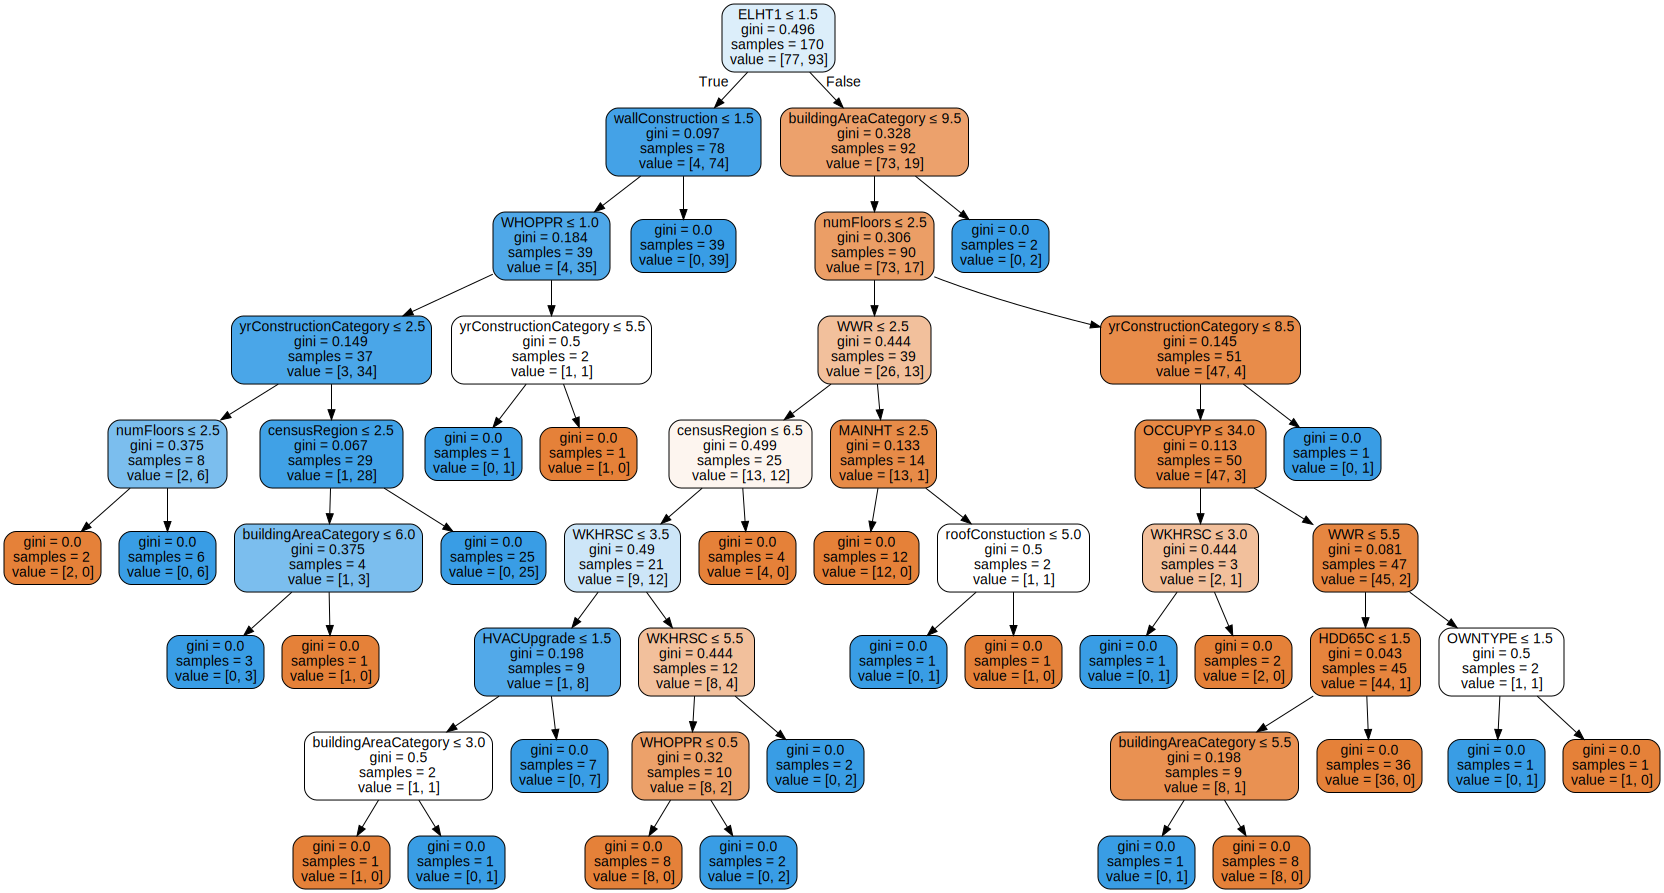

In [40]:
graph2

In [45]:
from sklearn.ensemble import BaggingClassifier
clf_bag=BaggingClassifier()
clf_bag.fit(X[:n,:],Y[:n])
print(clf_bag.score(X[n:m,:],Y[n:m]))
Y_bag=clf_bag.predict(X[n:m,:])
past_ana(Y_bag,Y[n:m])

0.7567567567567568
(y=1,Y=1): 22 (y=1.0,Y=0.0): 11 (y=0.0,Y=1.0): 7 (effective 1.0): 1.8333333333333333
             precision    recall  f1-score   support

        0.0       0.76      0.83      0.79        41
        1.0       0.76      0.67      0.71        33

avg / total       0.76      0.76      0.75        74



In [46]:
from sklearn.ensemble import ExtraTreesClassifier
clf_ETC=ExtraTreesClassifier()
clf_ETC.fit(X[:n,:],Y[:n])
print(clf_ETC.score(X[n:m,:],Y[n:m]))
Y_ETC=clf_ETC.predict(X[n:m,:])
past_ana(Y_ETC,Y[n:m])

0.8378378378378378
(y=1,Y=1): 23 (y=1.0,Y=0.0): 6 (y=0.0,Y=1.0): 6 (effective 1.0): 3.2857142857142856
             precision    recall  f1-score   support

        0.0       0.87      0.87      0.87        45
        1.0       0.79      0.79      0.79        29

avg / total       0.84      0.84      0.84        74



In [47]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
reg = LinearRegression()
reg.fit(X[:n,:],Y[:n])
reg.score(X[n:m,:],Y[n:m])

0.3102242481525439

In [54]:
from sklearn.feature_selection import SelectKBest, chi2
sel2=SelectKBest(chi2,k=8)
X_new=sel2.fit_transform(X,Y)
sel2.get_support(indices=True)

array([ 0,  2,  3,  4,  5, 11, 12, 24], dtype=int64)

Attributes Name WKHRSC max diff 0.1367346938775498
Attributes Name CDD65C max diff 0.0010204081632665396
Attributes Name ELHT1 max diff 0.6295918367346925
Attributes Name OCCUPYPC max diff 0.11122448979591915
Attributes Name STHT1 max diff 0.1257369614512477


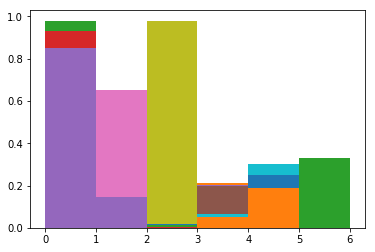

In [121]:
highInfluenceFactorsDetect('WKHRSC',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('CDD65C',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('ELHT1',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('OCCUPYPC',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('STHT1',7,HP,MP,LP,m1,m2,m3)

Attributes Name ELHT1 max diff 0.6295918367346925
legend num 2 row of data (2, 3)


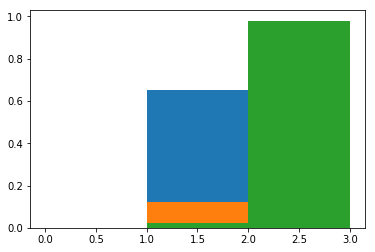

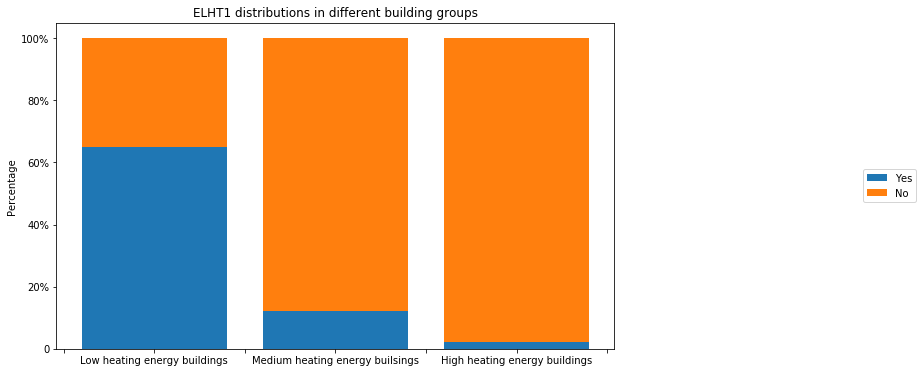

In [113]:
attri_name_ELHT1='ELHT1'
legends_dict_ELHT1={1:'Yes',2:'No',0:'Missing'}
bin_num_ELHT1=4
featureAnalysis(attri_name_ELHT1,bin_num_ELHT1,legends_dict_ELHT1,HP,MP,LP,m1,m2,m3)

In [ ]:
attri_name_ELHT1='ELHT1'
legends_dict_ELHT1={1:'Yes',2:'No',0:'Missing'}
bin_num_ELHT1=4
featureAnalysis(attri_name_ELHT1,bin_num_ELHT1,legends_dict_ELHT1,HP,MP,LP,m1,m2,m3)